In [ ]:
!pip install ortools

# **🩺 Workfore Planning Problem**
### **Workforce Planning Using OR-Tools**
---

## **📌 Problem Overview**
The **Workforce Planning Problem** is a **Integer Programming Problem** where we decide **number of nurses to deploy in shifts** while ensuring:
1. **Minimization of Total Deployment Costs**
2. **Staffing requirements are met** across time periods.
---

## **🛠️ Step 1: Install and Import Dependencies**

In [1]:
import pandas as pd
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

## **📅 Step 2: Define Problem Parameters**
To solve the **Workforce Planning Problem**, we first define the **core planning parameters**:
- Nurses needed per hourly timeblock
- Hourly time-block to shift mapping
- Daily manpower costs per shift

In [2]:
nurses_needed = [48, 79, 60, 88, 64, 89, 70, 43, 55, 16]

# Define the hourly nurse requirements from the provided image
time_periods = [
    "06-08", "08-10", "10-12", "12-14", "14-16",
    "16-18", "18-20", "20-22", "22-00", "00-06"
]

# Define shifts and their corresponding hourly block coverage
shift_mapping = {
    "Shift 1": ["06-08", "08-10", "10-12", "12-14"],
    "Shift 2": ["08-10", "10-12", "12-14", "14-16"],
    "Shift 3": ["12-14", "14-16", "16-18", "18-20"],
    "Shift 4": ["16-18", "18-20", "20-22", "22-00"],
    "Shift 5": ["22-00", "00-06"]
}

# Cost per nurse per shift
shift_costs = {
    "Shift 1": 170,
    "Shift 2": 180,
    "Shift 3": 156,
    "Shift 4": 180,
    "Shift 5": 205
}

## **📌 Step 3: Define and Solve the OR-Tools Model**

In [3]:
# Create solver instance
solver = pywraplp.Solver.CreateSolver('SCIP')

# Define decision variables (integer variables for nurses assigned per shift)
shift_vars = {shift: solver.IntVar(0, solver.infinity(), shift) for shift in shift_mapping.keys()}

# Define objective function: Minimize total deployment cost
solver.Minimize(solver.Sum(shift_vars[shift] * shift_costs[shift] for shift in shift_mapping.keys()))

# Define constraints: Staffing requirement per hourly block
for i, time_period in enumerate(time_periods):
    required_nurses = nurses_needed[i]
    
    # Sum nurses from shifts that cover this time period
    covered_by_shifts = [shift_vars[shift] for shift in shift_mapping if time_period in shift_mapping[shift]]
    
    if covered_by_shifts:
        solver.Add(solver.Sum(covered_by_shifts) >= required_nurses)

# Solve the problem
status = solver.Solve()



## **📊 Step 4: Visualizing the Results** 
1. Print the deployment plan
2. Visualize the deployment 

In [4]:
# Output results
if status == pywraplp.Solver.OPTIMAL:
    print("Optimal number of nurses to assign per shift:")
    for shift in shift_vars:
        print(f"{shift}: {shift_vars[shift].solution_value()}")
    print(f"Minimum Total Cost: {solver.Objective().Value()}")
else:
    print("No optimal solution found.")

Optimal number of nurses to assign per shift:
Shift 1: 61.0
Shift 2: 18.0
Shift 3: 46.0
Shift 4: 43.0
Shift 5: 16.0
Minimum Total Cost: 31805.999999999996


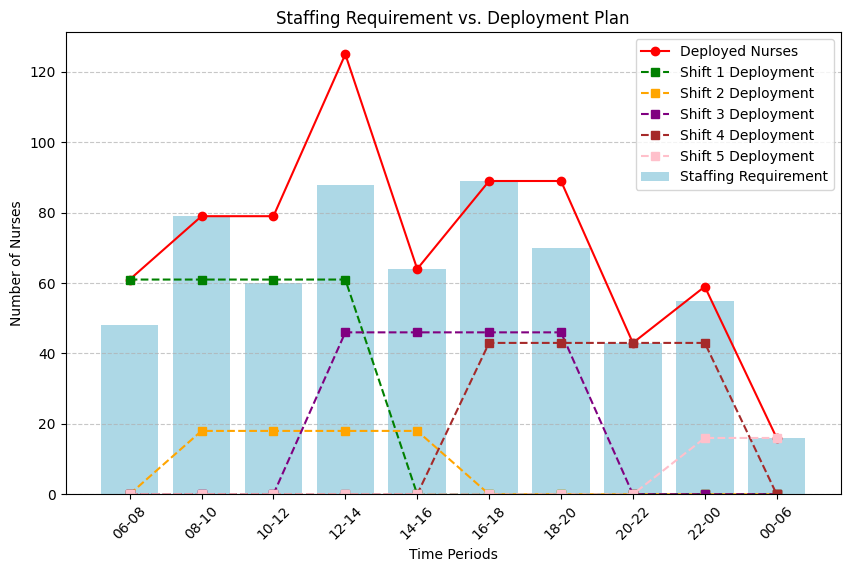

In [5]:
# Extract the optimal number of nurses assigned per shift from the solver
if status == pywraplp.Solver.OPTIMAL:
    optimal_nurses_per_shift = {shift: shift_vars[shift].solution_value() for shift in shift_vars}
else:
    optimal_nurses_per_shift = {shift: 0 for shift in shift_vars}  # Default to zero if no solution found

# Compute total deployment per hourly block
deployment_plan = {tp: 0 for tp in time_periods}  # Initialize

for shift, blocks in shift_mapping.items():
    for block in blocks:
        deployment_plan[block] += optimal_nurses_per_shift[shift]

# Extract deployed nurses in correct order
total_deployment = [deployment_plan[tp] for tp in time_periods]

# Extract manpower deployment per shift for visualization
manpower_deployment = {shift: [0] * len(time_periods) for shift in shift_mapping.keys()}

# Overlay manpower deployment per shift

for shift, blocks in shift_mapping.items():
    for i, period in enumerate(time_periods):
        if period in blocks:
            manpower_deployment[shift][i] = optimal_nurses_per_shift[shift]

# Plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for staffing requirements
ax.bar(time_periods, nurses_needed, color='lightblue', label="Staffing Requirement")

# Line chart for deployment plan
ax.plot(time_periods, total_deployment, marker='o', linestyle='-', color='red', label="Deployed Nurses")

colors = ['green', 'orange', 'purple', 'brown', 'pink']  # Assign distinct colors per shift

for idx, (shift, values) in enumerate(manpower_deployment.items()):
    ax.plot(time_periods, values, marker='s', linestyle='--', color=colors[idx], label=f"{shift} Deployment")


# Labels and title
ax.set_xlabel("Time Periods")
ax.set_ylabel("Number of Nurses")
ax.set_title("Staffing Requirement vs. Deployment Plan")
ax.legend()

# Display the graph
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
